# Implementation of the Easy21 game from David Silver's RL Slides.

## Describing the game

- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)
- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of red (probability 1/3) or black (probability
2/3).
- There are no aces or picture (face) cards in this game
- At the start of the game both the player and the dealer draw one black
card (fully observed)
- Each turn the player may either stick or hit
- If the player hits then she draws another card from the deck
- If the player sticks she receives no further cards
- The values of the player’s cards are added (black cards) or subtracted (red
cards)
- If the player’s sum exceeds 21, or becomes less than 1, then she “goes
bust” and loses the game (reward -1)
- If the player sticks then the dealer starts taking turns. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins; otherwise, the outcome – win (reward +1),
lose (reward -1), or draw (reward 0) – is the player with the largest sum.

### Part 1: Implementation of Easy21

State s is the tuple (top, sum), action a is 0 for hit and 1 for stick. 

In [1]:
import random, numpy as np

In [2]:
def draw_card():
    value = random.randint(1, 10)
    colour_value = random.random()
    if colour_value < 0.33:
        return -value
    else:
        return value

In [ ]:
def step(s, a): # s is the state (top card of dealer, total sum of cards of player) of the game, a is the action (hit or stick), shoud sample a next state s' and reward r.
    if a == 0: # hit
        if s[1] < 21:
            card_value = draw_card() # should return appropriate value of card with correct sign (black -> add, red -> subtract)
            s_new = (s[0], s[1] + card_value)
            if s_new[1] > 21 or s_new[1] < 1: # player busts
                return s_new, -1
            else:
                return s_new, 0
        else:
            return s, -1
    else: # stick
        dealer_card = draw_card()
        while dealer_card < 17: # dealer hits until the sum is at least 17
            dealer_card += draw_card()
        if dealer_card > 21: # dealer busts
            return s, 1
        elif dealer_card < s[1]: # player wins
            return s, 1
        elif dealer_card == s[1]: # draw
            return s, 0
        else: # dealer wins
            return s, -1

# What is the exact meaning of the "top card of the dealer"?, we are not updating that anywhere in the game, so not sure why it is needed.


### Step 2: Monte Carlo Control Implementation

In [4]:
# Initialize the value function, count of states, epsilon, N_0, and alpha.
N = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
V = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
N0 = 100

player_value = random.randint(1, 10)
dealer_value = random.randint(1, 10)

number_of_episodes = 10000000

for episode in range(number_of_episodes):
    player_value = random.randint(1, 10) # reset player value
    dealer_value = random.randint(1, 10) # reset dealer value
    s = (dealer_value, player_value) # initial state
    a = 0 if random.random() < 0.5 else 1 # choose first action randomly

    while True:
        s_new, r = step(s, a) # take a step in the game
        if s_new[1] >= 1 and s_new[1] <= 21:
            N[s_new[0], s_new[1], a] += 1 # update count of states
            alpha_t = 1 / N[s_new[0], s_new[1], a] # calculate alpha
            V[s_new[0], s_new[1], a] += alpha_t * (r + np.max(V[s_new[0], :, :]) - V[s_new[0], s_new[1], a]) # update value function

        if r != 0: # if the game is over, break the loop
            break

        s = s_new # update state
        epsilon_t = N0 / (N0 + N[s[0], s[1], a])
        a = np.argmax(V[s[0], s[1], :]) if random.random() > epsilon_t else random.randint(0, 1) # choose next action using epsilon-greedy policy


In [5]:
print("Value function for Easy21:"
      "\nHit Action:\n", V[:, :, 0],
      "\nStick Action:\n", V[:, :, 1])

Value function for Easy21:
Hit Action:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         14.64483049 14.64232128 14.64201352 14.640596   14.63848598
  14.64303456 14.65289719 14.64454359 14.64535135 14.64293476 14.64340024
  14.64230572 14.6381419  14.64158665 14.64731106 14.64502475 14.65025736
  14.65208706 14.650538   14.65667022 14.62810516]
 [ 0.         16.81289814 16.81704351 16.81684704 16.82166898 16.81728288
  16.82330265 16.81941285 16.81903391 16.81940072 16.81611441 16.82080405
  16.82126016 16.82341858 16.82587547 16.82041075 16.82320451 16.82212394
  16.82633975 16.82499186 16.83220929 16.81249743]
 [ 0.         13.84411204 13.84869675 13.84231572 13.84949227 13.84237922
  13.84680729 13.85079052 13.84847797 13.8469948  13.84370338 13.84597765
  13.84220931 13.

In [13]:
Z_0 = np.transpose(V[:, :, 0])
Z_1 = np.transpose(V[:, :, 1])
Z = np.maximum(Z_0, Z_1)
optimal_policy = np.argmax(V, axis=2)

In [14]:
print("\nOptimal Value Function:\n", Z)
print("\nOptimal Policy (0: Hit, 1: Stick):\n", optimal_policy)


Optimal Value Function:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.         14.64483049 16.81289814 13.84411204 16.78192589 11.83363856
  17.99670346 18.62596972 17.02895884 17.48790995 17.66547479]
 [ 0.         14.64232128 16.81704351 13.84869675 16.77695074 11.83166817
  17.99624649 18.62324171 17.04224866 17.49859445 17.66469668]
 [ 0.         14.64201352 16.81684704 13.84231572 16.78140991 11.83056153
  18.00080604 18.619232   17.03707787 17.49346219 17.66106607]
 [ 0.         14.640596   16.82166898 13.84949227 16.77187047 11.83010428
  17.99967322 18.62386619 17.02215942 17.49836201 17.66129197]
 [ 0.         14.63848598 16.81728288 13.84237922 16.77999754 11.82912715
  18.00504424 18.62719414 17.03690309 17.49832443 17.65823355]
 [ 0.         14.64303456 16.82330265 13.84680729 16.78120829 11.82869597
  18.00065916 18.6247019  17.03587149 17.50606206 17.6676801 ]
 [ 0.         14.652897

### Plotting the value function

In [8]:
import matplotlib.pyplot as plt

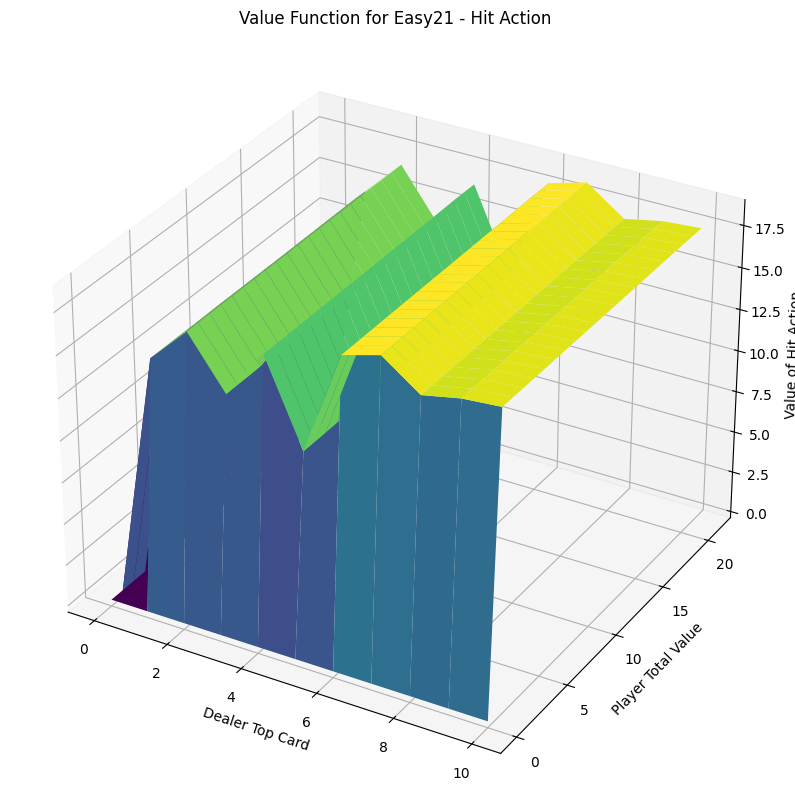

In [9]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(0, 11), np.arange(0, 22))
ax.plot_surface(X, Y, Z_0, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Hit Action')
plt.show()

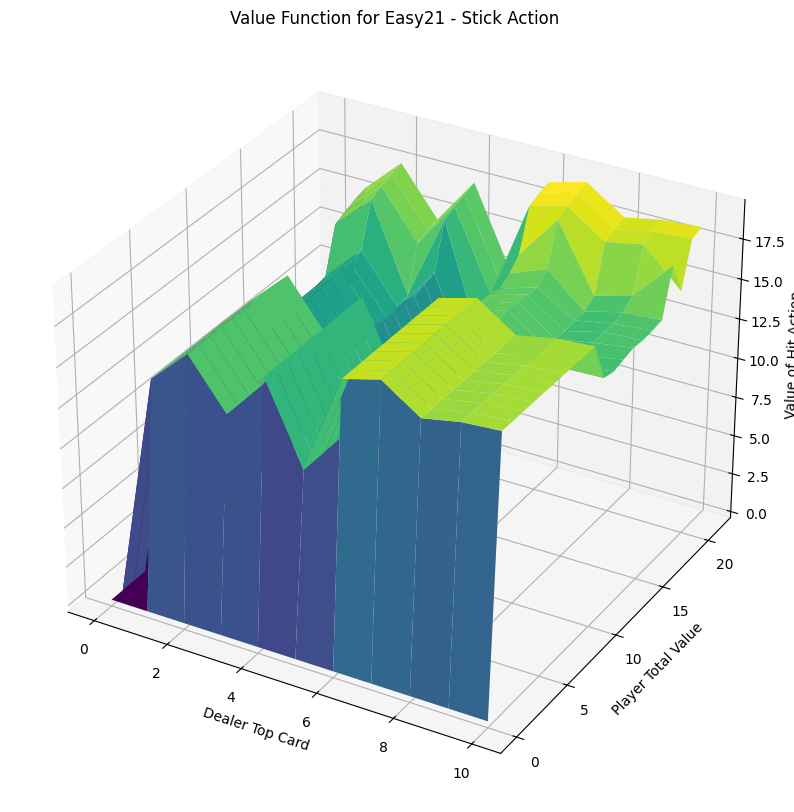

In [10]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_1, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Stick Action')
plt.show()

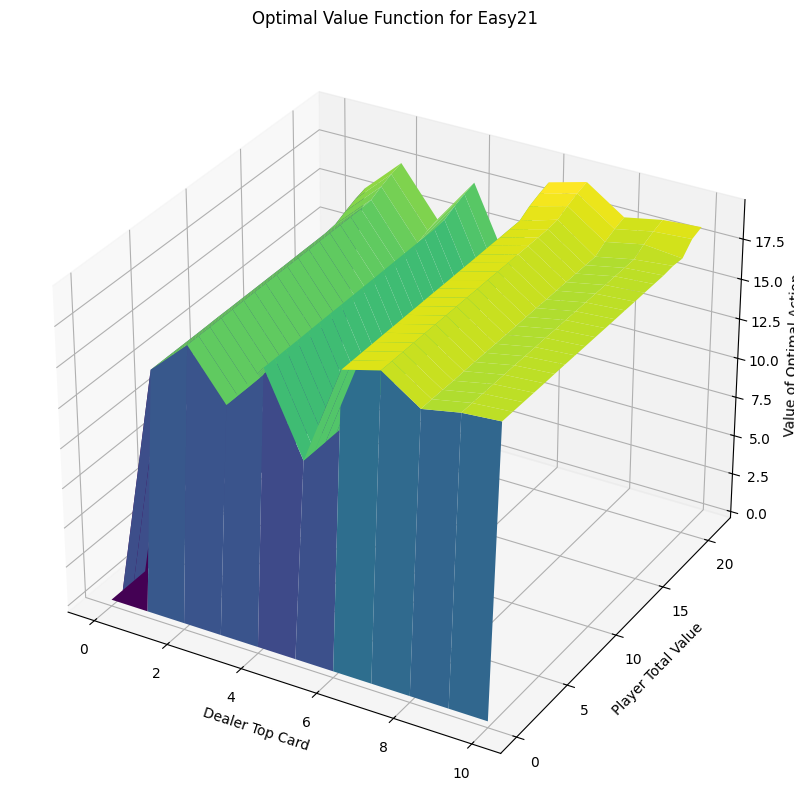

In [11]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Optimal Action')
ax.set_title('Optimal Value Function for Easy21')
plt.show()

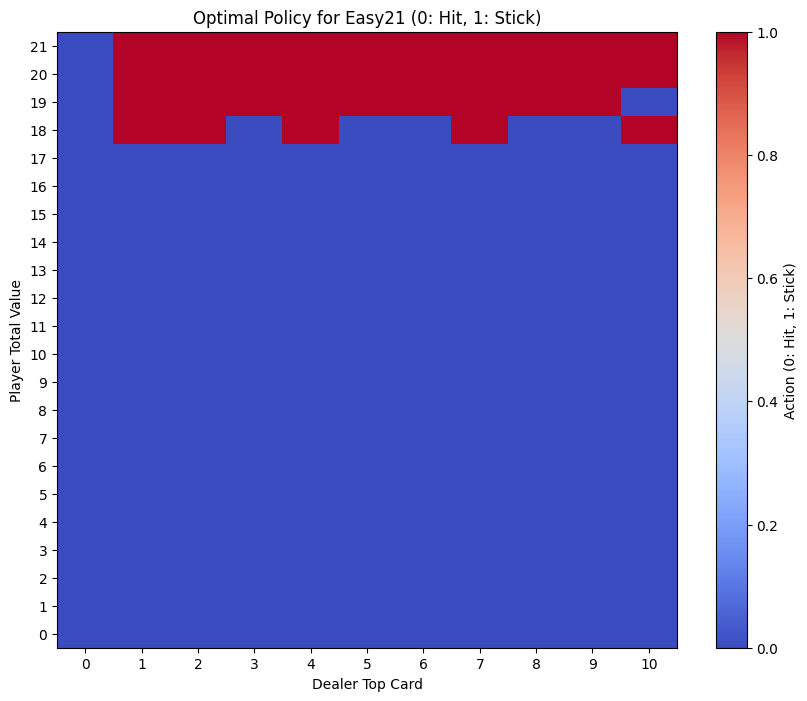

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy.T, origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Action (0: Hit, 1: Stick)')
plt.xlabel('Dealer Top Card')
plt.ylabel('Player Total Value')
plt.title('Optimal Policy for Easy21 (0: Hit, 1: Stick)')
plt.xticks(ticks=np.arange(optimal_policy.shape[0]), labels=np.arange(optimal_policy.shape[0]))
plt.yticks(ticks=np.arange(optimal_policy.shape[1]), labels=np.arange(optimal_policy.shape[1]))
plt.show()